## Optimisation de Portfolio

#### Les packages utilisés

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import empyrical
from scipy.optimize import minimize
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
from empyrical import (
    alpha,
    beta,
    alpha_beta_aligned,
    annual_volatility,
    cum_returns,
    annual_return,
    downside_risk,
    max_drawdown,
    sharpe_ratio,
    sortino_ratio,
    calmar_ratio,
    omega_ratio,
    tail_ratio
)

## Partie I : Rechargement de données

#### On charge les prix 'Adj close' des 5 valeurs

In [3]:
tlt = pd.read_csv("./TLT.csv")
spy = pd.read_csv("./SPY.csv")
qqq = pd.read_csv("./QQQ.csv")
iwm = pd.read_csv("./IWM.csv")
gld = pd.read_csv("./GLD.csv")
df_daily_close = pd.concat([gld['Date'],gld['Adj Close'],iwm['Adj Close'],qqq['Adj Close'],
                             spy['Adj Close'],tlt['Adj Close']],axis = 1, 
                                names =['Date','GLD','IWM','QQQ','SPY','TLT'])
df_daily_close.columns = ['Date','GLD','IWM','QQQ','SPY','TLT']

#### Les premiers 5 lignes du jeux de données

In [4]:
df_daily_close.head()

Date         GLD         IWM        QQQ         SPY        TLT
0  2014-01-02  118.000000  105.580299  82.197189  163.383347  88.082428
1  2014-01-03  119.290001  106.116951  81.603798  163.356522  88.082428
2  2014-01-06  119.500000  105.256462  81.302399  162.883148  88.453148
3  2014-01-07  118.820000  106.135452  82.055901  163.883560  88.677307
4  2014-01-08  118.120003  106.274254  82.234848  163.919250  88.435928

#### Calculer les daily returns en utilisant la fonction 'pct_change'

In [5]:
returns = df_daily_close.drop(['Date'], axis=1).pct_change()
returns['Date'] = df_daily_close.Date
returns.dropna(inplace = True)

returns.set_index(["Date"], inplace=True)
returns.head()

GLD       IWM       QQQ       SPY       TLT
Date                                                        
2014-01-03  0.010932  0.005083 -0.007219 -0.000164  0.000000
2014-01-06  0.001760 -0.008109 -0.003693 -0.002898  0.004209
2014-01-07 -0.005690  0.008351  0.009268  0.006142  0.002534
2014-01-08 -0.005891  0.001308  0.002181  0.000218 -0.002722
2014-01-09  0.002878  0.000261 -0.003321  0.000654  0.005849

In [6]:
pd.to_datetime(returns.index)

DatetimeIndex(['2014-01-03', '2014-01-06', '2014-01-07', '2014-01-08',
               '2014-01-09', '2014-01-10', '2014-01-13', '2014-01-14',
               '2014-01-15', '2014-01-16',
               ...
               '2019-09-24', '2019-09-25', '2019-09-26', '2019-09-27',
               '2019-09-30', '2019-10-01', '2019-10-02', '2019-10-03',
               '2019-10-04', '2019-10-07'],
              dtype='datetime64[ns]', name='Date', length=1450, freq=None)

## Partie II : Analyse de base

#### On regarde d'abord la performance de ces 5 valeurs

Text(0.5, 1.0, 'Cumulative returns for each stock')

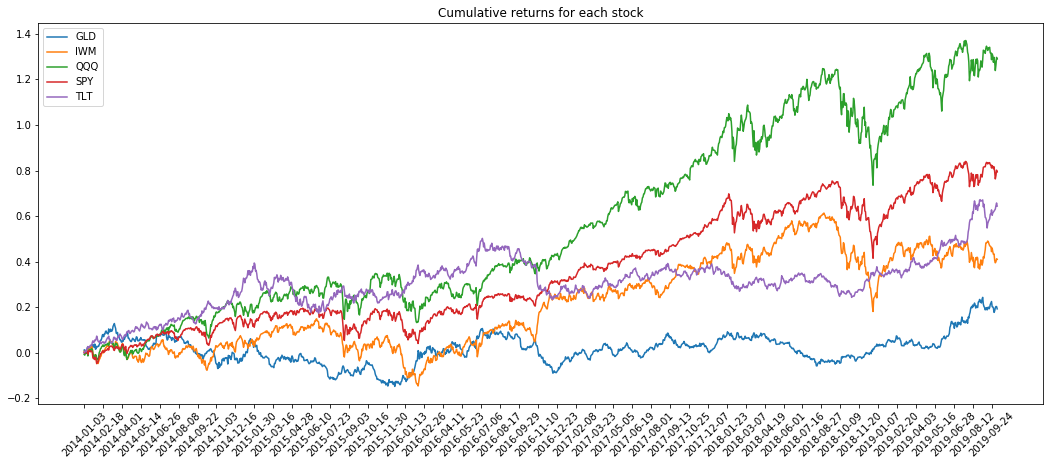

In [7]:
plt.rcParams['figure.figsize'] = (18.0, 7.0)
plt.rcParams['image.cmap'] = 'gray'
plt.plot((1+returns.GLD).cumprod()-1,label = 'GLD')
plt.plot((1+returns.IWM).cumprod()-1,label = 'IWM')
plt.plot((1+returns.QQQ).cumprod()-1,label = 'QQQ')
plt.plot((1+returns.SPY).cumprod()-1,label = 'SPY')
plt.plot((1+returns.TLT).cumprod()-1,label = 'TLT')
#plt.xticks([])
plt.xticks(returns.index[::30], rotation=45)
plt.legend()
plt.title('Cumulative returns for each stock')

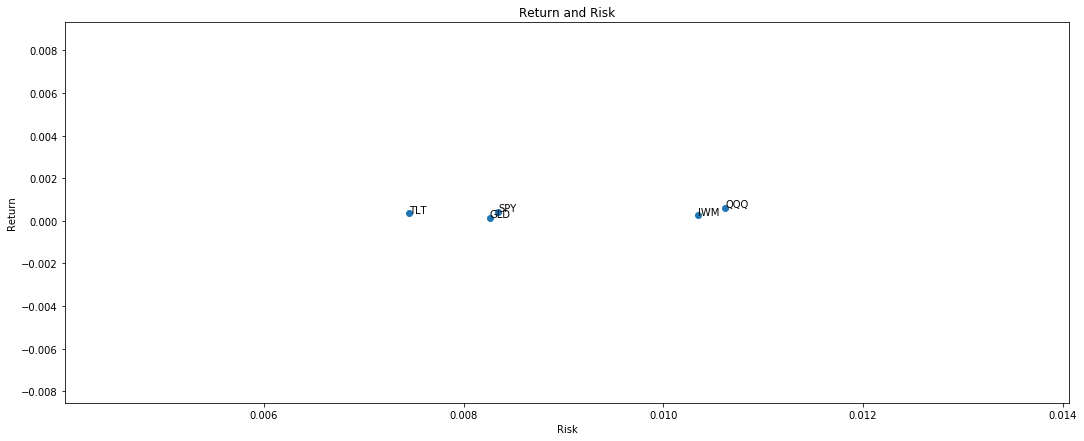

In [8]:
t1 = returns.std()
t2 = returns.mean()

symbols = ['GLD', 'IWM', 'QQQ', 'SPY','TLT']


fig, ax = plt.subplots()
ax.scatter(x=t1, y=t2)
ax.set(title='Return and Risk', xlabel='Risk', ylabel='Return')
for i, symbol in enumerate(symbols):
    ax.annotate(symbol, (t1[i], t2[i]))

plt.rcParams['figure.figsize'] = (11.0, 8.0)    
plt.show()

#### Histogramme de returns de chaque valeurs, on trouve que ils sont proches à loi normal

Text(0.5, 1.0, 'Histogramme of 5 stocks')

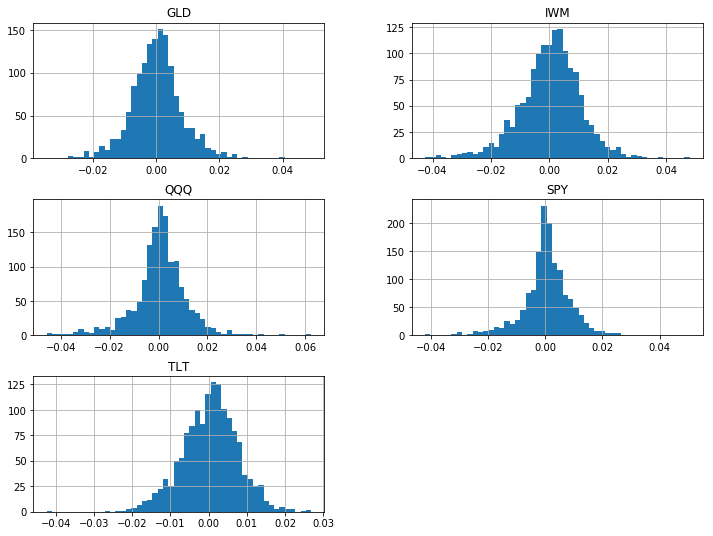

In [9]:
returns.hist(bins=50, figsize=(12, 9))
plt.title('Histogramme of 5 stocks')

#### On regarde aussi la relation entre ces 5 valeurs (matrice de corrélation) et trouve que SPY et QQQ sont fortement corrélés

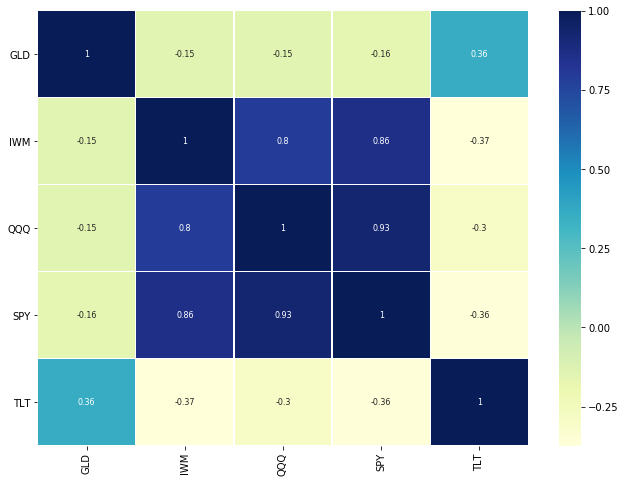

In [10]:
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

## Partie III : Application de la simulation Monte Carlo

#### On définit risk_free = 0.0005

In [11]:
risk_free = 0.0005

#### Fonction pour calculer omega ratio

In [12]:
def fun_omega(x):   # a function to calculate omaga ratio
    data = returns
    data['weighted_ret'] = data.iloc[:,0:5].mul(x, axis=1).sum(axis=1)
    data['up_ret'] = data.weighted_ret.map(lambda x: x if x>0.0005 else 0)
    data['down_ret'] = data.weighted_ret.map(lambda x: x if x<= 0.0005 else 0)
    return -data.up_ret.sum()/data.down_ret.sum()

#### Calculer la moyenne et la covariance des daily returns

In [13]:
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

#### Définir le nombre de simulation aléatoires du portefeuille = 25000

In [14]:
num_portfolios = 30000

#### Définir une matrice vide pour enregistrer les 25000 résultats

In [31]:
stocks = ['GLD','IWM','QQQ','SPY','TLT']
results = np.zeros((4+len(stocks),num_portfolios))

#### On calcule rendement(ret), équart-type(stdev), sharpe ratio et omega ratio pour chaque simulation
#### Pour calculer omega ratio, il faut définir un paramètre 'required_return', on le définit = 0.05

In [32]:
for i in range(num_portfolios):
    #générer les poids
    weights = np.random.random(len(stocks))
    #assurer la somme de poids = 1
    weights = weights / np.sum(weights)
    
    #calculer return, dev et return avec les poids
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(252)
    #returns_avec_poids = returns.mul(weights, axis=1).sum(axis=1)
       
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    #enregistrer Sharpe Ratio 
    results[2,i] = (results[0,i]- risk_free) / results[1,i]
    #enregistrer omega ratio
    #omega = omega_ratio(returns=returns_avec_poids, risk_free = risk_free, required_return = 0.05)
    omega = fun_omega(weights)
    results[3,i] = omega
    #enregistrer les poids
    for j in range(len(weights)):
        results[j+4,i] = weights[j]

#### On peut bien obtenir un tableau qui présente tous les résultats

In [33]:
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe','omega', stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_frame.head(15) # Afficher les 15 premiers lignes

ret     stdev    sharpe     omega       GLD       IWM       QQQ  \
0   0.099376  0.093431  1.058279  1.196540  0.092949  0.335939  0.262881   
1   0.088395  0.090712  0.968936  1.179100  0.488515  0.019791  0.288427   
2   0.098645  0.088429  1.109874  1.211004  0.305855  0.055774  0.292717   
3   0.099036  0.099172  0.993587  1.189392  0.195078  0.203256  0.249039   
4   0.099039  0.090250  1.091844  1.207833  0.181182  0.183828  0.239192   
5   0.098471  0.099495  0.984675  1.186761  0.107545  0.272283  0.183180   
6   0.090060  0.081345  1.100986  1.206951  0.260865  0.148275  0.138986   
7   0.084571  0.073921  1.137312  1.208770  0.251992  0.211401  0.091570   
8   0.094782  0.086401  1.091215  1.206933  0.216042  0.164410  0.182937   
9   0.090494  0.097913  0.919120  1.170558  0.297509  0.274178  0.261921   
10  0.101492  0.086275  1.170587  1.223422  0.254747  0.068956  0.306269   
11  0.101988  0.101196  1.002888  1.190638  0.029091  0.279608  0.165199   
12  0.087069  0.071158  1.216586  1.224482  0.284261  0.085943  0.094978   
13  0.107875  0.109992  0.976201  1.189064  0.023589  0.212795  0.207865   
14  0.102471  0.101911  1.000589  1.190824  0.097816  0.253071  0.237297   

         SPY       TLT  
0   0.043596  0.264635  
1   0.187673  0.015594  
2   0.234220  0.111434  
3   0.245244  0.107381  
4   0.215687  0.180111  
5   0.265976  0.171016  
6   0.282207  0.169667  
7   0.186701  0.258336  
8   0.268273  0.168338  
9   0.104255  0.062138  
10  0.202462  0.167566  
11  0.299970  0.226132  
12  0.275088  0.259730  
13  0.386722  0.169030  
14  0.240851  0.170965

#### Trouver les positions avec le plus grand sharpe/omega ratio et le plus petit équart-type
#### étoile rouge représente le plus grand sharpe ratio
#### étoile jaune représente le plus grand omega ratio
#### étoile verte représente le plus petit variance

In [34]:
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
max_omega_port = results_frame.iloc[results_frame['omega'].idxmax()]

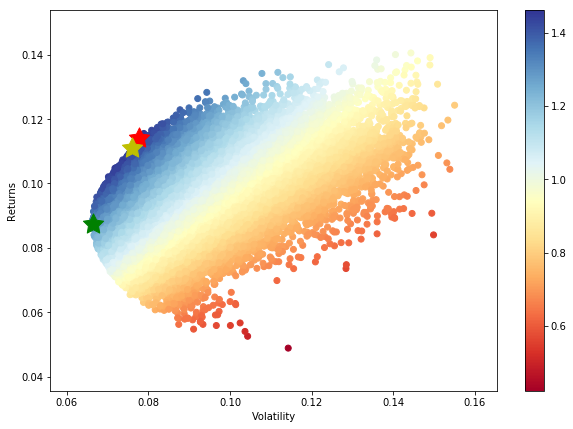

In [35]:
#create scatter plot coloured by Sharpe Ratio
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
#étoile rouge représente le plus grand sharpe ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=450)
#étoile jaune représente le plus grand omega ratio
plt.scatter(max_omega_port[1],max_omega_port[0],marker=(5,1,0),color='y',s=450)
#étoile verte représente le plus petit variance
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=450)

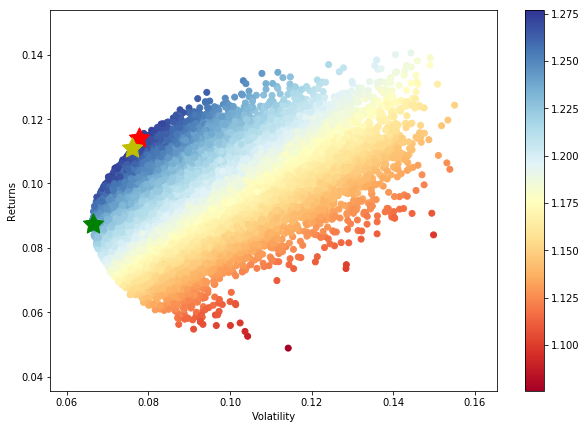

In [36]:
#create scatter plot coloured by Omega Ratio
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.omega,cmap='RdYlBu')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.colorbar()
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=450)
plt.scatter(max_omega_port[1],max_omega_port[0],marker=(5,1,0),color='y',s=450)
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=450)

#### La meilleure partition qui maximise sharpe ratio parmi ces 25000 simulations

In [37]:
print(max_sharpe_port)

ret       0.114150
stdev     0.077811
sharpe    1.460578
omega     1.275140
GLD       0.028865
IWM       0.011053
QQQ       0.313515
SPY       0.130080
TLT       0.516487
Name: 4496, dtype: float64


#### La meilleure partition qui maximise omega ratio parmi ces 25000 simulations

In [38]:
print(max_omega_port)

ret       0.111111
stdev     0.076008
sharpe    1.455263
omega     1.276768
GLD       0.025547
IWM       0.001316
QQQ       0.223127
SPY       0.274446
TLT       0.475565
Name: 29996, dtype: float64


#### La meilleure partition qui minimise la variance parmi ces 25000 simulations

In [39]:
print(min_vol_port)

ret       0.087299
stdev     0.066358
sharpe    1.308050
omega     1.242384
GLD       0.199227
IWM       0.057241
QQQ       0.010207
SPY       0.306978
TLT       0.426347
Name: 26709, dtype: float64


In [40]:
p_max_sharpe = np.asarray((max_sharpe_port[4],max_sharpe_port[5],max_sharpe_port[6],max_sharpe_port[7],max_sharpe_port[8]))
p_max_omega = np.asarray((max_omega_port[4],max_omega_port[5],max_omega_port[6],max_omega_port[7],max_omega_port[8]))
p_min_std = np.asarray((min_vol_port[4],min_vol_port[5],min_vol_port[6],min_vol_port[7],min_vol_port[8]))

#### On regarde les trois courbes de daily returns cumulé

In [41]:
returns = df_daily_close.drop(['Date'], axis=1).pct_change()
returns['Date'] = df_daily_close.Date
returns.dropna(inplace = True)

returns.set_index(["Date"], inplace=True)
returns.head()

GLD       IWM       QQQ       SPY       TLT
Date                                                        
2014-01-03  0.010932  0.005083 -0.007219 -0.000164  0.000000
2014-01-06  0.001760 -0.008109 -0.003693 -0.002898  0.004209
2014-01-07 -0.005690  0.008351  0.009268  0.006142  0.002534
2014-01-08 -0.005891  0.001308  0.002181  0.000218 -0.002722
2014-01-09  0.002878  0.000261 -0.003321  0.000654  0.005849

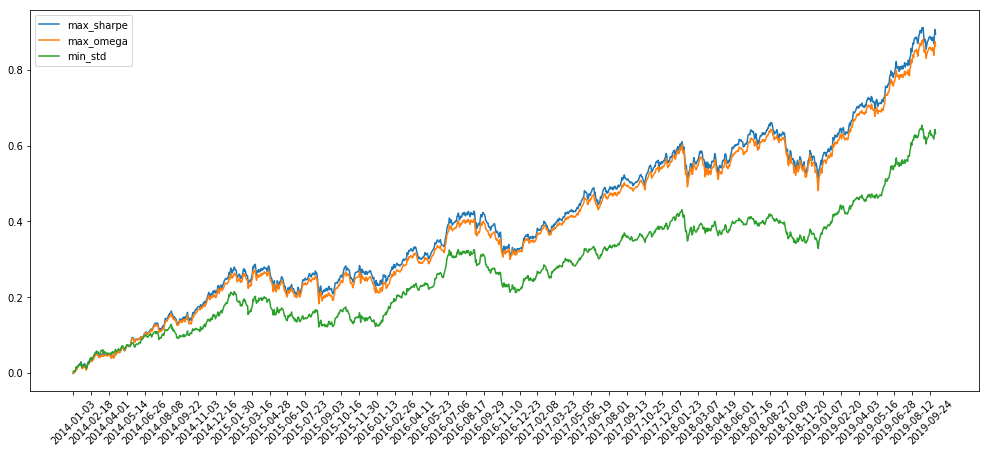

In [42]:
plt.rcParams['figure.figsize'] = (17.0, 7.0)
plt.rcParams['image.cmap'] = 'gray'
plt.plot((1+returns.mul(p_max_sharpe, axis=1).sum(axis=1)).cumprod()-1,label = 'max_sharpe')
plt.plot((1+returns.mul(p_max_omega, axis=1).sum(axis=1)).cumprod()-1,label = 'max_omega')
plt.plot((1+returns.mul(p_min_std, axis=1).sum(axis=1)).cumprod()-1,label = 'min_std')
plt.xticks(returns.index[::30], rotation=45)
plt.legend()

## Partie III : Calcul analytiques 

#### On utilise la foncion 'minimize' comme solver pour trouver la meilleur partition qui maximize sharpe ratio

In [16]:
def fun(args):
    a,b,c = args
    v = lambda x: -( np.sum(mean_daily_returns * x) * a - b )/ (np.sqrt(np.dot(x.T,np.dot(cov_matrix, x))) * np.sqrt(c))
    return v

def con(args):
    cons = ({'type': 'ineq', 'fun': lambda x:x[0]},\
              {'type': 'ineq', 'fun': lambda x:x[1]},\
             {'type': 'ineq', 'fun': lambda x:x[2]},\
                {'type': 'ineq', 'fun': lambda x:x[3]},\
            {'type': 'ineq', 'fun': lambda x:x[4]},\
             {'type': 'eq', 'fun': lambda x: sum(x) - args})
    return cons



if __name__ == "__main__":
    args = (252,0.0005,252)  
    cons = con(1)
    x0 = np.asarray((0.2,0.2,0.2,0.2,0.2))
    
    res = minimize(fun(args), x0, method='SLSQP',constraints=cons)  
    print(res.success)
    

True


#### Le résultat qui maximise sharpe ratio

In [44]:
ret_analytique = np.sum(mean_daily_returns * res.x) * 252
stdev_analytique = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, res.x))) * np.sqrt(252)
sharpe_analytique = -res.fun
poid_GLD = round(res.x[0],6)
poid_IWM = round(res.x[1],6)
poid_QQQ = round(res.x[2],6)
poid_SPY = round(res.x[3],6)
poid_TLT = round(res.x[4],6)
print('ret :',ret_analytique)
print('stdev :',stdev_analytique)
print('sharpe :', -res.fun)
print('GLD :',poid_GLD)
print('IWM :',poid_IWM)
print('QQQ :',poid_QQQ)
print('SPY :',poid_SPY)
print('TLT :',poid_TLT)

ret : 0.11178944363611036
stdev : 0.06718477961154777
sharpe : 1.4669720002215525
GLD : 0.028478
IWM : 0.0
QQQ : 0.256302
SPY : 0.19541
TLT : 0.51981


#### On peut les comparer avec le résultat de Monte Carlo, on trouve que les deux résultats sont proches

In [45]:
print(max_sharpe_port)

ret       0.114150
stdev     0.077811
sharpe    1.460578
omega     1.275140
GLD       0.028865
IWM       0.011053
QQQ       0.313515
SPY       0.130080
TLT       0.516487
Name: 4496, dtype: float64


#### Maintenant on les compare avec les courbes, aussi très proche

In [46]:
p_max_sharpe_ana = np.asarray((poid_GLD,poid_IWM,poid_QQQ,poid_SPY,poid_TLT))

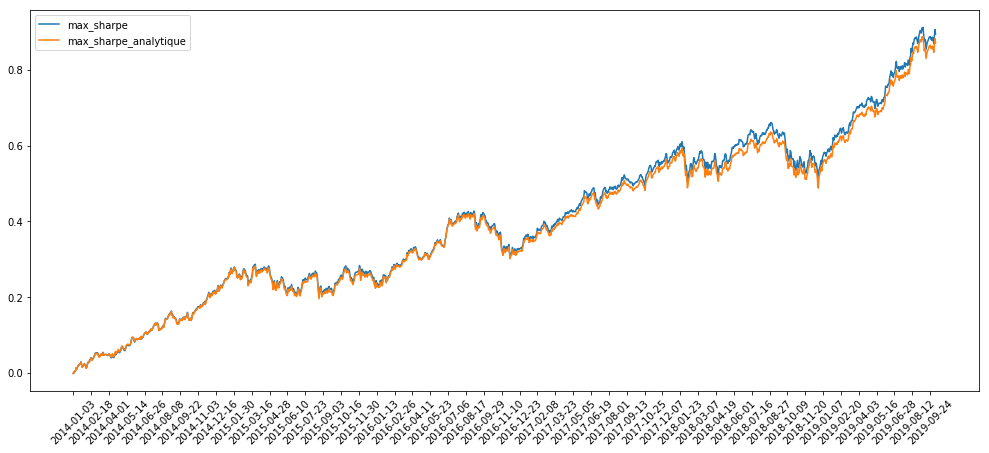

In [47]:
plt.rcParams['figure.figsize'] = (17.0, 7.0)
plt.rcParams['image.cmap'] = 'gray'
plt.plot((1+returns.mul(p_max_sharpe, axis=1).sum(axis=1)).cumprod()-1,label = 'max_sharpe')
plt.plot((1+returns.mul(p_max_sharpe_ana, axis=1).sum(axis=1)).cumprod()-1,label = 'max_sharpe_analytique')
#plt.xticks(rotation = 45)
plt.xticks(returns.index[::30], rotation=45)
plt.legend()

### Pour le calcul analytique d'omega ratio voir fichier excel, la fonction python est mois performant que solver de excel
### De plus, nous avons changé la méthode de calcul pour omega ratio, explication voir fichier excel
### résultats :
##### GLD : 0.013320
##### IWM : 0.000000
##### QQQ : 0.262067
##### SPY : 0.226561
##### TLT : 0.498051
##### Omega : 1.277353

#### On compare aussi les courbes avec résultats MC et Calcul analytique, c'est proche

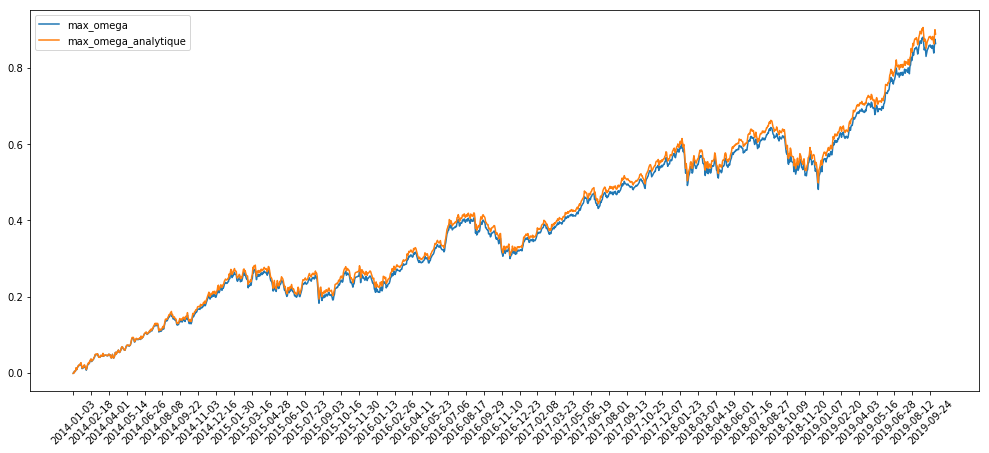

In [48]:
p_max_omega_ana = np.asarray((0.013320,0,0.262067,0.226561,0.498051))
plt.rcParams['figure.figsize'] = (17.0, 7.0)
plt.rcParams['image.cmap'] = 'gray'
plt.plot((1+returns.mul(p_max_omega, axis=1).sum(axis=1)).cumprod()-1,label = 'max_omega')
plt.plot((1+returns.mul(p_max_omega_ana, axis=1).sum(axis=1)).cumprod()-1,label = 'max_omega_analytique')
plt.xticks(returns.index[::30], rotation=45)
plt.legend()

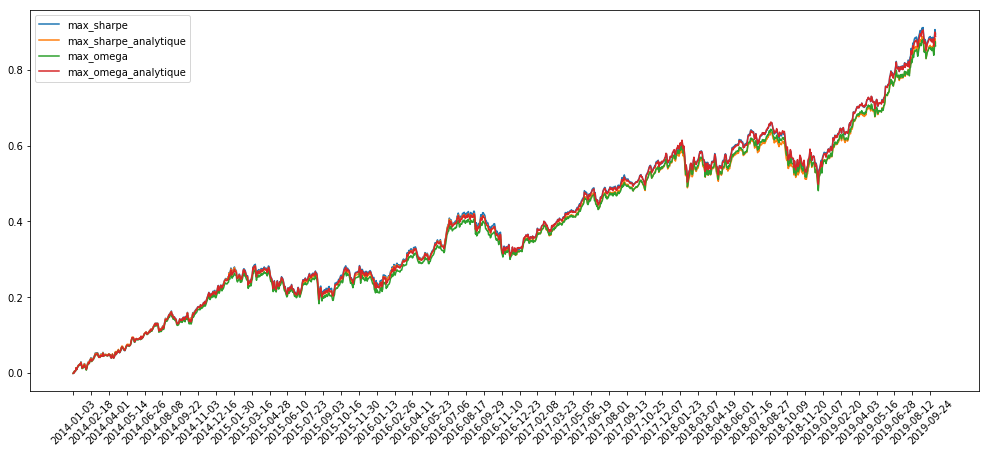

In [49]:
plt.rcParams['figure.figsize'] = (17.0, 7.0)
plt.rcParams['image.cmap'] = 'gray'
plt.plot((1+returns.mul(p_max_sharpe, axis=1).sum(axis=1)).cumprod()-1,label = 'max_sharpe')
plt.plot((1+returns.mul(p_max_sharpe_ana, axis=1).sum(axis=1)).cumprod()-1,label = 'max_sharpe_analytique')

plt.plot((1+returns.mul(p_max_omega, axis=1).sum(axis=1)).cumprod()-1,label = 'max_omega')
plt.plot((1+returns.mul(p_max_omega_ana, axis=1).sum(axis=1)).cumprod()-1,label = 'max_omega_analytique')
plt.xticks(returns.index[::30], rotation=45)
plt.legend()

Quelques idées sur l'application de AI pour l'optimisation de portfolio :

1. Le principe est d'estimer la tendance de 'returns'de chaque valeur 
2. Les facteurs qui peuvent impacter les 'returns' :
    - le temps (jour férié, saison, day of week, month of year) => Time series forecasting model
    - la politique => neural network method
    - l'émotion de la population => neural network method
    - ......

En gros, on peut d'abord transformer cette question en prédiction sur des données TimeSeries de Machine Learning.

Des méthodes sur la prédiction sur des données de TimeSeries :

1. Modèle Naive
2. Décomposition saisonnière
3. ARIMA, SARIMA
4. Modèle linéaire dynamique
5. LSTM

## Partie IV : Simulation de trading

#### Cette simulation est basée sur les données de 2014 à 2019. On utilise la proportion suivant calculé avant :

In [51]:
print(p_max_sharpe)

[0.02886539 0.01105252 0.31351498 0.13008017 0.51648693]


#### Calculer 'Daily Return' pondéré :

In [54]:
returns['dreturn']= returns[['GLD','IWM','QQQ','SPY','TLT']].mul(p_max_sharpe, axis=1).sum(axis=1)

In [55]:
returns.head(5)

GLD       IWM       QQQ       SPY       TLT   dreturn
Date                                                                  
2014-01-03  0.010932  0.005083 -0.007219 -0.000164  0.000000 -0.001913
2014-01-06  0.001760 -0.008109 -0.003693 -0.002898  0.004209  0.000600
2014-01-07 -0.005690  0.008351  0.009268  0.006142  0.002534  0.004941
2014-01-08 -0.005891  0.001308  0.002181  0.000218 -0.002722 -0.000849
2014-01-09  0.002878  0.000261 -0.003321  0.000654  0.005849  0.002151

#### On regarde d'abord en quelles périodes il existe plus de 'baisse' (daily return < 0) avec 3 graphiques :

In [56]:
returns['flag']=returns.dreturn.map(lambda x:'+' if x >= 0 else '-')

In [57]:
returns.index = pd.to_datetime(returns.index)

In [58]:
returns['month']= returns.index.month
returns['year']= returns.index.year
returns['day']= returns.index.day

In [59]:
baisse = returns.loc[returns.flag == '-']
#test.columns = ['day','count']
#plt.bar(test)

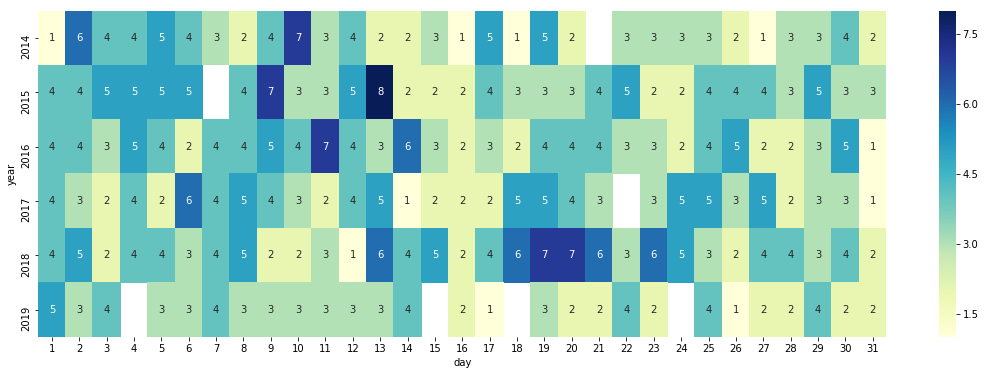

In [60]:
test = baisse.groupby(['year','day']).size().unstack()
plt.figure(figsize=(19,6))
sns.heatmap(test, annot = True, cmap="YlGnBu")

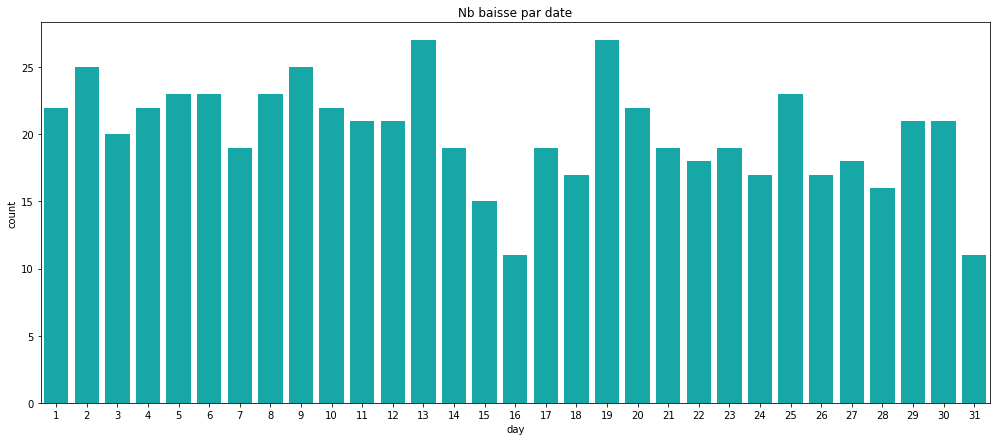

In [61]:
sns.countplot(x="day", data=baisse, color = 'c')
plt.title('Nb baisse par date')
plt.show()

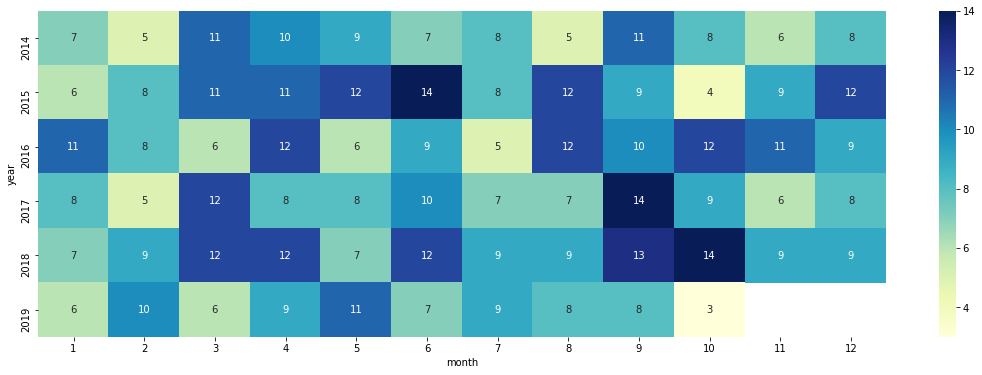

In [62]:
test = baisse.groupby(['year','month']).size().unstack()

plt.figure(figsize=(19,6))
sns.heatmap(test, annot = True, cmap="YlGnBu")

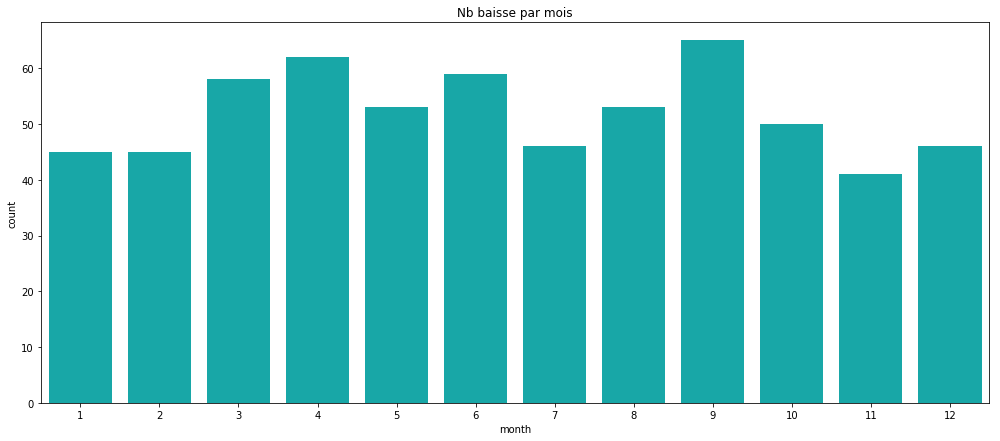

In [63]:
sns.countplot(x="month", data=baisse, color = 'c')
plt.title('Nb baisse par mois')
plt.show()

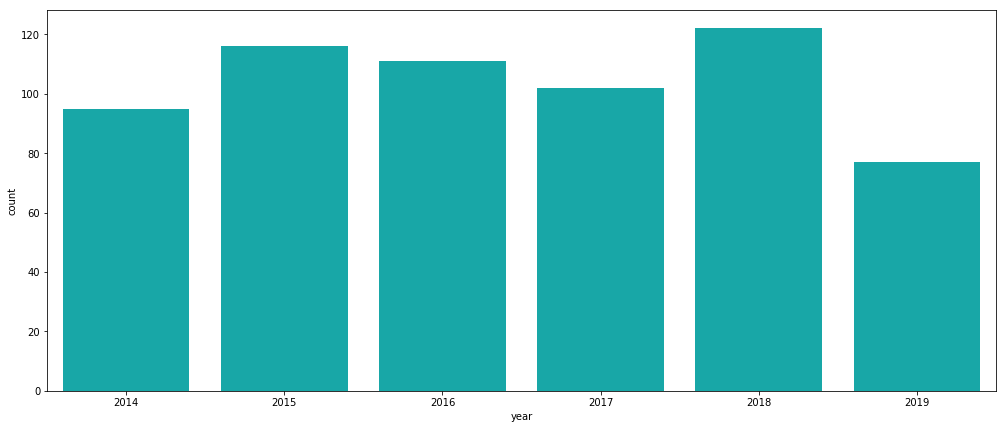

In [64]:
sns.countplot(x="year", data=baisse, color = 'c')
plt.show('Nb baisse par ans')
plt.show()

### 1. Stratégie avec les ventes nb de jours de baisse :

#### Si on garde tout le temps les actions, on peut gagner 0.895 fois le principal :

In [66]:
l = (1+ returns.dreturn).cumprod()-1
print(l[-1])

0.8950531041310736


#### Si on garde les actions simplement pendant les jours où 'return' > 0, on peut gagner 20.157 fois le principal ：

In [67]:
l = (1+ returns.loc[returns.flag == '+'].dreturn).cumprod()-1
print(l[-1])

20.157248997384308


#### Si on vend les actions pendant les jours avec 5 'return' négative successivement (on garde quand même les action si il existe 1/2/3/4 jours de baisse), on peut gagner 1.05 fois le principal ：

In [68]:
baisse['gap'] = baisse.index.to_series().diff().to_list()

In [69]:
import datetime
d = datetime.timedelta(days=1)

In [70]:
oneday = baisse.loc[baisse.gap == d]
#oneday.head(10)

In [71]:
oneday['gap_2'] = oneday.index.to_series().diff().to_list()
#oneday.head(10)

In [72]:
twodays = oneday.loc[oneday.gap_2 == d]
twodays['gap_3'] = twodays.index.to_series().diff().to_list()
threedays = twodays.loc[twodays.gap_2 == d]
#threedays.head(10)

In [73]:
fourdays = twodays.loc[twodays.gap_3 == d]
fourdays['gap_4'] = fourdays.index.to_series().diff().to_list()
#fourdays.head(10)

In [74]:
result = fourdays[fourdays['gap_4']==d].index
results = list(result- datetime.timedelta(days = 4))
results = results + list(result- datetime.timedelta(days = 3))
results = results + list(result- datetime.timedelta(days = 2))
results = results + list(result- datetime.timedelta(days = 1))
results = results + list(result)

In [75]:
results = set(returns.index.to_list()) - set(results) 
df_result = returns.loc[results].sort_index(ascending=True)
l = (1+ df_result.dreturn).cumprod()-1
print(l[-1])

1.0512223554514009


#### Si on vend les actions pendant les jours avec 4 'return' négative successivement (on garde quand même les action si il existe 1/2/3 jours de baisse), on peut gagner 1.3 fois le principal 

In [76]:
result = threedays[threedays['gap_3']==d].index
results = list(result- datetime.timedelta(days = 3))
results = results + list(result- datetime.timedelta(days = 2))
results = results + list(result- datetime.timedelta(days = 1))
results = results + list(result)

In [77]:
results = set(returns.index.to_list()) - set(results) 
df_result = returns.loc[results].sort_index(ascending=True)
l = (1+ df_result.dreturn).cumprod()-1
print(l[-1])

1.3074055871986152


#### Si on vend les actions pendant les jours avec 3 'return' négative successivement (on garde quand même les action si il existe 1/2 jours de baisse), on peut gagner 2.56 fois le principal 

In [78]:
result = twodays[twodays['gap_2']==d].index
results = list(result- datetime.timedelta(days = 2))
results = results + list(result- datetime.timedelta(days = 1))
results = results + list(result)

In [79]:
results = set(returns.index.to_list()) - set(results) 
df_result = returns.loc[results].sort_index(ascending=True)
l = (1+ df_result.dreturn).cumprod()-1
print(l[-1])

2.5686519909288807


### 2. Stratégie avec l'ajustement de poids

In [27]:
llist = []
restdf = returns[125:]  # can be changed with 20/60/125/250 ......
testdf = returns.iloc[:125]
mean_daily_returns = testdf[['GLD','IWM','QQQ','SPY','TLT']].mean()
cov_matrix = testdf[['GLD','IWM','QQQ','SPY','TLT']].cov()
res = minimize(fun(args), x0, method='SLSQP',constraints=cons)
new_proportion = res.x


while restdf.shape[0] > 0 :
    testdf = restdf.iloc[:125]
    restdf = restdf.iloc[125:]
    testdf['dreturn']= testdf[['GLD','IWM','QQQ','SPY','TLT']].mul(new_proportion, axis=1).sum(axis=1)
    l = (1+ testdf.dreturn).cumprod()-1
    llist.append(l[-1])    
    testdf = restdf.iloc[:125]
    mean_daily_returns = testdf[['GLD','IWM','QQQ','SPY','TLT']].mean()
    cov_matrix = testdf[['GLD','IWM','QQQ','SPY','TLT']].cov()
    res = minimize(fun(args), x0, method='SLSQP',constraints=cons)  
    if res.success:
        new_proportion = res.x
    


In [117]:
print(llist)

[0.0966913472417108, 0.13281996344310865, 0.040727638003757116, 0.06152872590826375, 0.11670247807602618, 0.22451469382814193, 0.13846443584922974, 0.0915871322402575, 0.10097775969976608, 0.02161006791513964, 0.13962351326922406, 0.06509340005833941]


In [118]:
tttt = pd.DataFrame(llist)

In [119]:
tttt.columns= ['returns']

In [120]:
lll = (1 + tttt['returns']).cumprod()-1

In [121]:
print(lll) 

0     0.096691
1     0.242354
2     0.292952
3     0.372506
4     0.532680
5     0.876790
6     1.136658
7     1.332349
8     1.567864
9     1.623356
10    1.989638
11    2.184244
Name: returns, dtype: float64


In [68]:
# compare with original proportion
returns['dreturn']= returns[['GLD','IWM','QQQ','SPY','TLT']].mul(p_max_sharpe, axis=1).sum(axis=1)
l = (1+ returns.dreturn).cumprod()-1
print(l[-1])

0.8791755155831582


In [ ]:
#note :
#250 => 1.16
#125 => 2.18
#60 => 2.85
#30 => 9.31

### 3. Stratégie moving average crossover

In [87]:
print(p_max_sharpe)

[0.02886539 0.01105252 0.31351498 0.13008017 0.51648693]


In [88]:
tlt = pd.read_csv("./TLT.csv")
spy = pd.read_csv("./SPY.csv")
qqq = pd.read_csv("./QQQ.csv")
iwm = pd.read_csv("./IWM.csv")
gld = pd.read_csv("./GLD.csv")
df_daily_close = pd.concat([gld['Date'],gld['Adj Close'],iwm['Adj Close'],qqq['Adj Close'],
                             spy['Adj Close'],tlt['Adj Close']],axis = 1, 
                                names =['Date','GLD','IWM','QQQ','SPY','TLT'])
df_daily_close.columns = ['Date','GLD','IWM','QQQ','SPY','TLT']
df_daily_close.set_index(["Date"], inplace=True)
df_daily_close.head()

GLD         IWM        QQQ         SPY        TLT
Date                                                                
2014-01-02  118.000000  105.580299  82.197189  163.383347  88.082428
2014-01-03  119.290001  106.116951  81.603798  163.356522  88.082428
2014-01-06  119.500000  105.256462  81.302399  162.883148  88.453148
2014-01-07  118.820000  106.135452  82.055901  163.883560  88.677307
2014-01-08  118.120003  106.274254  82.234848  163.919250  88.435928

In [89]:
window_short = 20
window_long = 60
SD = 0.05
df_daily_close['dclose']= df_daily_close.mul(p_max_sharpe, axis=1).sum(axis=1)
df_daily_close['short_window'] = np.round(df_daily_close['dclose'].rolling(window=window_short).mean(), 2)
df_daily_close['long_window'] = np.round(df_daily_close['dclose'].rolling(window=window_long).mean(), 2)
df_daily_close[['dclose', 'short_window', 'long_window']].tail()

dclose  short_window  long_window
Date                                             
2019-10-01  176.518913        177.27       175.10
2019-10-02  175.051025        177.08       175.15
2019-10-03  176.691804        176.97       175.23
2019-10-04  178.630164        176.93       175.35
2019-10-07  177.623506        176.91       175.44

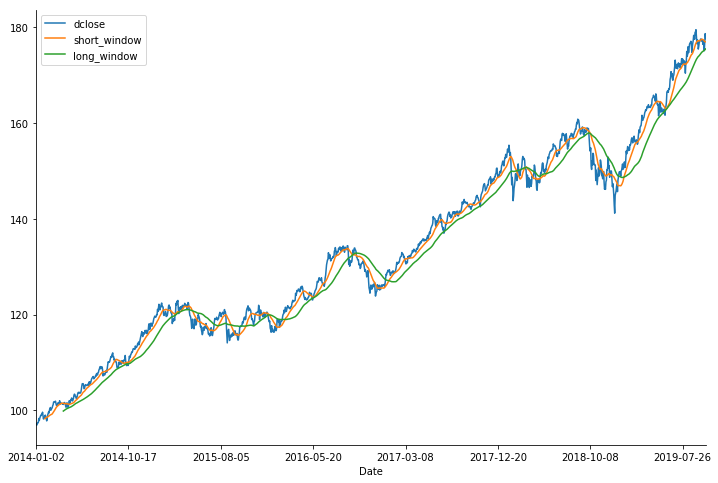

In [90]:
df_daily_close[['dclose', 'short_window', 'long_window']].plot(grid=False, figsize=(12,8))
sns.despine()

In [91]:
df_daily_close['s-l'] = df_daily_close['short_window'] - df_daily_close['long_window']
df_daily_close['s-l'].tail()

Date
2019-10-01    2.17
2019-10-02    1.93
2019-10-03    1.74
2019-10-04    1.58
2019-10-07    1.47
Name: s-l, dtype: float64

In [92]:
df_daily_close['Regime'] = np.where(df_daily_close['s-l'] > df_daily_close['long_window']*0.005, 1, 0)
df_daily_close['Regime'].value_counts()

1    933
0    518
Name: Regime, dtype: int64

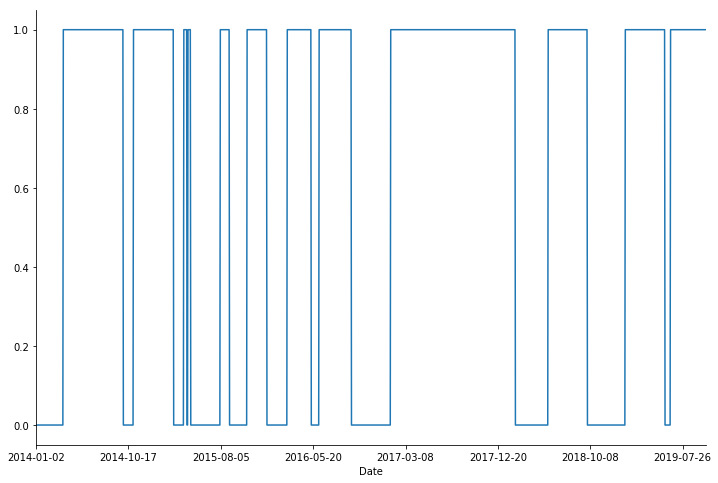

In [93]:
df_daily_close['Regime'].plot(grid=False, lw=1.5, figsize=(12,8))
#1时持有，0时卖出
sns.despine()

In [94]:
returns.shape

(1450, 10)

In [102]:
result = df_daily_close[df_daily_close['Regime']== 0].index
results = set(returns.index.to_list()) - set(results) 
df_result = returns.loc[results].sort_index(ascending=True)
l = (1+ df_result.dreturn).cumprod()-1
print(l)


Date
2014-01-03    0.001048
2014-01-06    0.002074
2014-01-07    0.004228
2014-01-08    0.002064
2014-01-09    0.004185
2014-01-10    0.014436
2014-01-13    0.013688
2014-01-14    0.015024
2014-01-15    0.016605
2014-01-16    0.019632
2014-01-17    0.022425
2014-01-21    0.022018
2014-01-22    0.020551
2014-01-23    0.031800
2014-01-24    0.029387
2014-01-27    0.020135
2014-01-28    0.020895
2014-01-29    0.024634
2014-01-30    0.022568
2014-01-31    0.025215
2014-02-06    0.027422
2014-02-07    0.035804
2014-02-10    0.040685
2014-02-11    0.045670
2014-02-12    0.044361
2014-02-13    0.051739
2014-02-14    0.056803
2014-02-18    0.058589
2014-02-19    0.052773
2014-02-20    0.054873
                ...   
2019-08-26    6.018570
2019-08-27    6.030795
2019-08-28    6.057427
2019-08-29    6.085567
2019-08-30    6.076038
2019-09-03    6.075192
2019-09-04    6.123075
2019-09-05    6.092831
2019-09-06    6.076228
2019-09-09    6.066462
2019-09-10    6.043613
2019-09-11    6.102421
2019-0

Text(0.5, 1.0, 'Cumulative daily return with double moving average strategy')

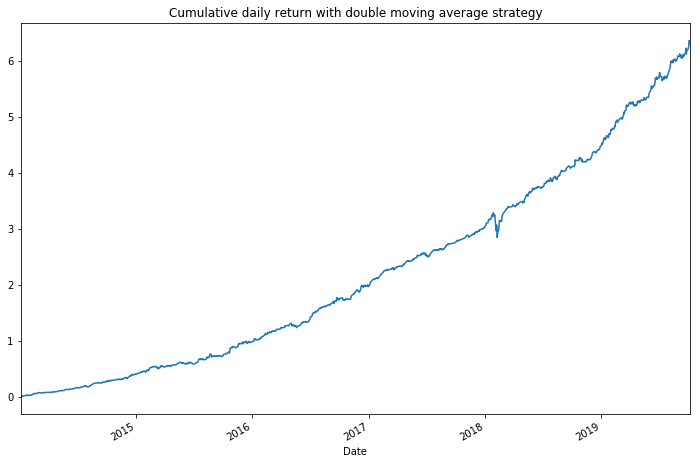

In [103]:
l.plot(grid=False, figsize=(12,8))
plt.title('Cumulative daily return with double moving average strategy')